In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go
# import plotly.figure_factory as ff
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# from nltk.tokenize import word_tokenize as wt 
# from collections import Counter
import gensim
# import textblob
import spacy

## **Plan of Action**

- Load the data
- Drop unnecessary columns and rows
- Removal of stop words.
- Feature engineering;
    - Glove-twitter-100
- Begin modelling
    - Algorithms to use;
        - k-Nearest Neighbors.
        - Decision Trees.
        - Random Forest.
        - Gradient Boosting.
        - Logistic Regression
- Evaluation;
    - F1-score_macro
    - AUC
    - ROC

In [2]:
df_clean = pd.read_csv('../../../cleaned_reviews.csv')

In [3]:
df_clean.shape

(17340, 4)

In [4]:
df_clean.columns

Index(['sentiments', 'cleaned_review', 'cleaned_review_length',
       'review_score'],
      dtype='object')

In [5]:
df_clean.drop(columns=['cleaned_review_length','review_score'],inplace=True)

Checking for Null Vaules and Duplicates

In [6]:
df_clean.isna().sum()

sentiments        0
cleaned_review    3
dtype: int64

In [7]:
df_clean.dropna(inplace=True)

In [8]:
df_clean.shape

(17337, 2)

In [9]:
from spacy.lang.en.stop_words import STOP_WORDS

# print(STOP_WORDS,'\n') # <- set of Spacy's default stop words
all_stopwords = STOP_WORDS
# Adding several stopwords
# all_stopwords |= {'not',"no", "n't", 'n’t','n‘t','cannot','none','without','against'}

# Removing several stop words
all_stopwords-= {'not',"no", "n't", 'n’t','n‘t','cannot','none','without','against','off','against','too'}
my_stop_words = set(all_stopwords) # My own stop words

In [10]:
print(my_stop_words)

{'did', 'be', 'put', 'even', 'third', 'were', 'one', 'why', 'anyhow', 'because', 'six', 'than', '’s', 'regarding', 'latter', 'move', 'whence', 'whoever', 'few', 'into', 'the', 'before', 'her', 'nowhere', 'would', 'being', 'used', 'somewhere', 'afterwards', 'becomes', '‘m', 'which', 'latterly', 'other', 'never', 'more', 'above', 'both', 'out', 'if', 'sixty', 'though', 'please', 'its', 'therefore', 'various', 'meanwhile', 'someone', 'side', 'last', 'whither', 'themselves', '‘ll', 'through', 'whose', 'here', 'became', 'further', 'to', 'across', 'due', 'thru', 'hundred', 'when', 'although', 'those', 'about', 'seems', 'bottom', 'us', 'should', 'three', 'is', 'fifty', 'under', 'unless', 'empty', 'serious', 'becoming', 'i', 'are', 'whatever', 'was', 'every', 'what', 'ever', 'while', 'go', 'several', 'for', 'name', 'seeming', 'via', 'may', 'former', 'hereupon', 'sometimes', 'amongst', 'somehow', 'there', 'until', 'say', 'everywhere', 'herein', '‘ve', '‘s', 'below', 'eight', "'re", 'yourselves'

In [11]:
df_clean

,sentiments,cleaned_review
0,positive,i wish would have gotten one earlier love it a...
1,neutral,i ve learned this lesson again open the packag...
2,neutral,it is so slow and lags find better option
3,neutral,roller ball stopped working within months of m...
4,neutral,i like the color and size but it few days out ...
...,...,...
17335,positive,i love this speaker and love can take it anywh...
17336,positive,i use it in my house easy to connect and loud ...
17337,positive,the bass is good and the battery is amazing mu...
17338,positive,love it


In [12]:
nlp = spacy.load("en_core_web_sm")

In [13]:
def spacy_tokeniser(sent):
    sent = sent.strip().lower()
    doc = nlp(sent)
    mytokens = [token.lemma_ for token in doc if token.text not in my_stop_words]
    return mytokens

In [14]:
df_clean['tokens']= df_clean['cleaned_review'].apply(spacy_tokeniser)

In [15]:
df_clean.head()

,sentiments,cleaned_review,tokens
0,positive,i wish would have gotten one earlier love it a...,"[wish, get, early, love, make, work, laptop, e..."
1,neutral,i ve learned this lesson again open the packag...,"[ve, learn, lesson, open, package, use, produc..."
2,neutral,it is so slow and lags find better option,"[slow, lag, find, well, option]"
3,neutral,roller ball stopped working within months of m...,"[roller, ball, stop, work, month, minimal, use..."
4,neutral,i like the color and size but it few days out ...,"[like, color, size, day, return, period, not, ..."


In [16]:
# Dropping unnecessary columns
df_clean.drop(columns=['cleaned_review'],inplace=True)

Sentiment Mapping

In [17]:
sentiment_mapping = {'negative':-1,'neutral':0,'positive':1}
df_clean['sentiment_label'] = df_clean.sentiments.map(sentiment_mapping)

In [18]:
df_clean.drop(columns=['sentiments'],inplace=True)

In [19]:
import pickle
# Loading saved word2vec glove_twitter_25.pkl
vectorizer = pickle.load(open('../../../../../../word2vec_files/glove_twitter_100.pkl', "rb"))

In [20]:
# Checking word embeddings file
print(type(vectorizer))
print(vectorizer['apple'])
print(len(vectorizer['apple']))

<class 'gensim.models.keyedvectors.KeyedVectors'>
[ 2.8061e-01 -6.0638e-01 -1.2934e-01  2.2574e-01 -7.6619e-01  5.1619e-01
 -4.6546e-01 -6.3632e-01  7.8836e-01 -4.3195e-01  4.8141e-01  2.7200e-01
 -2.6397e+00 -8.0155e-01  2.5805e-01  4.5710e-01 -8.7276e-02  7.4016e-01
  4.1159e-01 -3.0584e-01 -4.1132e-01 -5.5931e-01 -2.8586e-01  5.7392e-01
 -1.8626e-01 -9.0524e-01  6.0254e-01 -3.2129e-01 -5.3851e-02 -4.0918e-01
 -6.1063e-02  1.6648e-01 -7.6920e-01 -2.3111e-01  7.5962e-01 -2.1642e-01
 -9.2763e-02  1.2083e-01 -6.2506e-02  7.6517e-01 -5.3649e-01  3.2121e-01
 -1.7949e+00 -3.9649e-01  6.5510e-01  1.1611e-01 -1.1009e-01  1.4413e-01
 -4.8815e-01 -3.8031e-02 -7.5876e-02 -2.2033e-01 -9.3380e-01  5.4502e-01
  4.7419e-01  7.6589e-02  4.1670e-01 -5.1088e-01 -9.2422e-02 -6.2191e-01
 -4.4231e-01 -7.7107e-01  1.8660e-01 -4.0941e-02  6.3400e-01 -1.3089e-01
  5.3294e-01  2.4260e-01 -1.1011e-01 -4.2530e-01  4.5074e-02 -2.2056e-01
 -4.1872e-01  1.6032e-03 -9.1142e-01 -1.1381e-01 -6.8964e-01  3.1535e-01
 

In [21]:
pairs = [
    ('car', 'minivan'),   # a minivan is a kind of car
    ('car', 'bicycle'),   # still a wheeled vehicle
    ('car', 'airplane'),  # ok, no wheels, but still a vehicle
    ('car', 'cereal'),    # ... and so on
    ('car', 'communism'),
]

print("Similarity of pairs")
for index,words in enumerate(pairs):
    print(f"{words}: {vectorizer.similarity(words[0], words[1])}")

Similarity of pairs
('car', 'minivan'): 0.4417693018913269
('car', 'bicycle'): 0.5397422313690186
('car', 'airplane'): 0.5560004711151123
('car', 'cereal'): 0.34161612391471863
('car', 'communism'): -0.008989468216896057


In [22]:
def topn10(a:str,b:str,c):
    topn = vectorizer.most_similar(positive=[a,b], topn=c) 
    print(f"Words close to {a} and {b}\n")
    for x in topn:
        print(x)
topn10('ebay','amazon',10) # Slot in yours and see the magic

Words close to ebay and amazon

('store', 0.7595343589782715)
('kindle', 0.7490434050559998)
('deals', 0.7183388471603394)
('shop', 0.7013905048370361)
('buy', 0.6885556578636169)
('purchase', 0.6828194260597229)
('price', 0.674116313457489)
('shipping', 0.6710423231124878)
('discount', 0.6700250506401062)
('ebook', 0.6657071709632874)


In [23]:
from sklearn.decomposition import PCA
def decompose(word_list:list,n:int):
    words_vectors = np.array([vectorizer[word] for word in word_list])

    # print(words_vectors) # prints out a 30 array vector for each word

    pca = PCA(n_components=n)
    result = pca.fit_transform(words_vectors)
    # print(result)

    fig, ax = plt.subplots(figsize=(10,10))
    print(f"Components ranges from 0 -> {n-1}\nWhat pair of components would you like to visualise? ")
    a = input('Component one> ')
    b = input('Component two> ')
    scattered = sns.scatterplot(x=result[:,int(a)],y=result[:,int(b)])

    for index,word in enumerate(word_list):
        # plt.annotate(word,xy=(result[index,0],result[index,1]))
        scattered.text(x=result[index,int(a)],y=result[index,int(b)],s=word)

    ax.set_title(f"Visualisation of word vectors using components {a} and {b}",fontdict={'fontsize':15})
    plt.show()

Components ranges from 0 -> 1
What pair of components would you like to visualise? 


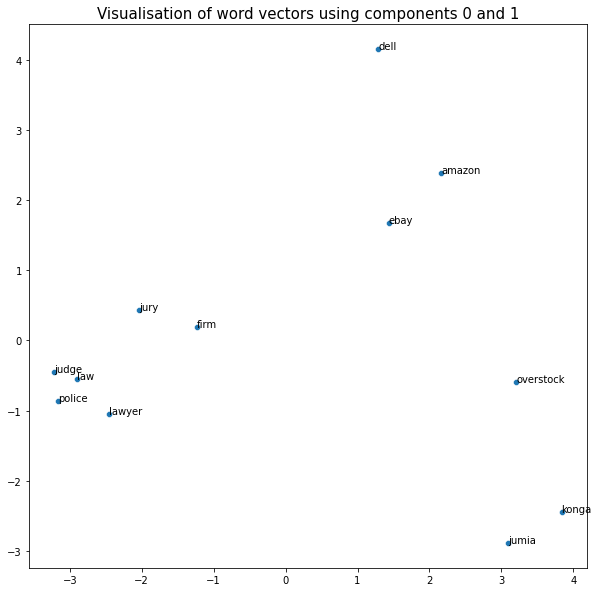

In [24]:
words  = ['amazon','ebay','jumia', 'konga','overstock','dell', 'law','firm','judge','lawyer','jury','police'] # Create your own list here
decompose(words,2) # Adjust the components as you wish

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,cross_val_score

# The algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [26]:
df_clean

,tokens,sentiment_label
0,"[wish, get, early, love, make, work, laptop, e...",1
1,"[ve, learn, lesson, open, package, use, produc...",0
2,"[slow, lag, find, well, option]",0
3,"[roller, ball, stop, work, month, minimal, use...",0
4,"[like, color, size, day, return, period, not, ...",0
...,...,...
17335,"[love, speaker, love, charge, phone, work, no,...",1
17336,"[use, house, easy, connect, loud, clear, music]",1
17337,"[bass, good, battery, amazing, well, charge, t...",1
17338,[love],1


In [27]:
# Vecctoriser of Word2vec
def sent_vec(sent):
    vector_size = vectorizer.vector_size
    w2v_resolution = np.zeros(vector_size)
    # print(w2v_resolution)
    ctr = 1
    for w in sent:
        if w in vectorizer:
            ctr += 1
            w2v_resolution += vectorizer[w]
    w2v_resolution = w2v_resolution/ctr
    # print(w2v_resolution)
    return w2v_resolution

In [28]:
df_clean["vectors"] = df_clean['tokens'].apply(sent_vec)

In [29]:
df_clean.sample(n=5,random_state=42)

,tokens,sentiment_label,vectors
14785,"[meet, need]",0,"[-0.08132100043197472, 0.4599999984105428, 0.0..."
14534,"[shop, great, speaker, sound, excellent, happy]",1,"[0.06981828702347619, 0.1283642915742738, -0.0..."
16246,"[no, light, show, charge, not, turn, light, ch...",-1,"[0.006175247819295951, 0.1882284271663853, -0...."
6385,"[connectivity, issue, right, box, contact, sel...",0,"[0.0707915038543029, -0.04294133445041047, -0...."
424,"[don, buy, inconvenient, rechargeable, know, m...",-1,"[0.05964590846137567, -0.19522072544152086, -0..."


In [30]:
X  =df_clean['vectors'].to_list()
y = df_clean['sentiment_label'].to_list()

In [31]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y,test_size=.2,random_state=42, 
                                            stratify=y)

In [32]:
len(X[0])

100

In [33]:
models = {
    "DT": DecisionTreeClassifier(max_depth=3,random_state=42),
    "RF": RandomForestClassifier(max_depth=3,random_state=42),
    "GB": GradientBoostingClassifier(max_depth=3,random_state=42),
    "KNN": KNeighborsClassifier(),
    "LR": LogisticRegression(multi_class='multinomial',solver='lbfgs'),
    "HGB": HistGradientBoostingClassifier(max_depth=3,random_state=42)
}

In [34]:
# https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f
# The abov link explains why f1_macro was used
model_results_f1_macro = []
model_names = []
model_mean = []

In [35]:
my_cv = StratifiedShuffleSplit(n_splits=5,test_size=.1,random_state=42) # 10% for validation 
scoring = 'f1_macro'
for name, model in models.items():
    model_names.append(name) # append each name of the model
    print(model) # print the model name for checks
    cv_results = cross_val_score(model,X_train,y_train,scoring=scoring,cv=my_cv,n_jobs=-2) 
    cv_results_list = cv_results.tolist() # Turning the array to a list
    model_results_f1_macro.append(cv_results_list) # append validation results
    model_mean.append(cv_results.mean()) # append the mean

DecisionTreeClassifier(max_depth=3, random_state=42)
RandomForestClassifier(max_depth=3, random_state=42)
GradientBoostingClassifier(random_state=42)
KNeighborsClassifier()
LogisticRegression(multi_class='multinomial')
HistGradientBoostingClassifier(max_depth=3, random_state=42)


In [36]:
print(model_results_f1_macro)
print(model_names)
print(model_mean)

[[0.44654821375722503, 0.45307802588041474, 0.4403560943804011, 0.45003775184769684, 0.4415382821870116], [0.45022606020852, 0.4504591824799606, 0.4468141123442862, 0.4591892803863679, 0.4600241695789921], [0.6565566212841735, 0.6476520901841852, 0.6657824225248867, 0.6842576908931743, 0.6688434463393028], [0.6081883867118688, 0.6210192089059103, 0.6154386498524449, 0.6070482336671029, 0.6218075450732594], [0.6245149519555482, 0.6383783588517932, 0.6833625488188502, 0.6941191883316485, 0.6657069699307279], [0.6562691254128059, 0.6804401886162892, 0.6827090195523207, 0.6909830589590085, 0.7095181456021006]]
['DT', 'RF', 'GB', 'KNN', 'LR', 'HGB']
[0.44631167361054985, 0.4533425609996254, 0.6646184542451444, 0.6147004048421173, 0.6612164035777136, 0.683983907628505]


In [37]:
# Creating a Dictionary of results
f1score_result_dict = dict(zip(model_names,model_results_f1_macro))
f1score_mean_dict = dict(zip(model_names,model_mean))

In [38]:
# Creating a Dataframe of results
f1score_result_frame = pd.DataFrame(f1score_result_dict)
f1score_mean_frame = pd.Series(f1score_mean_dict).to_frame('mean_f1_score').reset_index()
f1score_mean_frame.rename(columns={'index':'models'},inplace=True)

In [39]:
f1score_result_frame

,DT,RF,GB,KNN,LR,HGB
0,0.446548,0.450226,0.656557,0.608188,0.624515,0.656269
1,0.453078,0.450459,0.647652,0.621019,0.638378,0.680440
2,0.440356,0.446814,0.665782,0.615439,0.683363,0.682709
3,0.450038,0.459189,0.684258,0.607048,0.694119,0.690983
4,0.441538,0.460024,0.668843,0.621808,0.665707,0.709518


In [40]:
f1score_result_frame.to_csv("validation_w2v_100/w2v_100_f1score_results.csv",index=False)

In [41]:
f1score_mean_frame.sort_values(by='mean_f1_score',ascending=False)

,models,mean_f1_score
5,HGB,0.683984
2,GB,0.664618
4,LR,0.661216
3,KNN,0.614700
1,RF,0.453343
0,DT,0.446312


In [42]:
f1score_mean_frame.to_csv("validation_w2v_100/w2v_100_f1score_mean_results.csv")

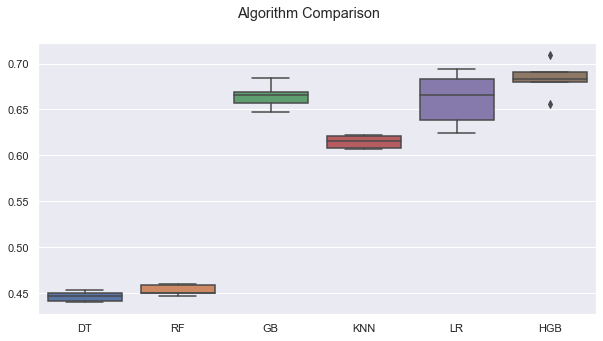

In [43]:
sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=f1score_result_frame)
ax.set_xticklabels(model_names)
fig.suptitle('Algorithm Comparison')
plt.show()

Based off the plot above, the top three algorithms are;
1. HistGradientBoostingClassifier
2. GradientBoostingClassifier & Logistic regression

In [45]:
X = df_clean['vectors'].to_list()
y = df_clean['sentiment_label'].to_list()

In [46]:
from sklearn.model_selection import GridSearchCV

In [47]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y,test_size=.2,random_state=42, 
                                            stratify=y)

In [48]:
# Without PCA
pipe = Pipeline([('clf',HistGradientBoostingClassifier(max_depth=3,random_state=42))])

In [49]:
paramter_grid = {
                'clf__learning_rate':[0.001,0.01,0.1,1],
                'clf__max_iter':[100,200,300],
                'clf__max_leaf_nodes':[20,30,31],
                'clf__min_samples_leaf':[20,50,80,110],
                'clf__warm_start':[True,False],
                }
my_cv = StratifiedShuffleSplit(n_splits=5,test_size=.1,random_state=42)

In [50]:
mygrid = GridSearchCV(pipe,param_grid=paramter_grid,cv=my_cv,scoring='f1_macro')
mygrid.fit(X_train,y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.1,
            train_size=None),
             estimator=Pipeline(steps=[('clf',
                                        HistGradientBoostingClassifier(max_depth=3,
                                                                       random_state=42))]),
             param_grid={'clf__learning_rate': [0.001, 0.01, 0.1, 1],
                         'clf__max_iter': [100, 200, 300],
                         'clf__max_leaf_nodes': [20, 30, 31],
                         'clf__min_samples_leaf': [20, 50, 80, 110],
                         'clf__warm_start': [True, False]},
             scoring='f1_macro')

In [51]:
print(f"Best params: {mygrid.best_params_}\n")
print(f"Best estimator: {mygrid.best_estimator_}\n")
print(f"Best validation score: {mygrid.best_score_}")

Best params: {'clf__learning_rate': 0.1, 'clf__max_iter': 300, 'clf__max_leaf_nodes': 20, 'clf__min_samples_leaf': 80, 'clf__warm_start': True}

Best estimator: Pipeline(steps=[('clf',
                 HistGradientBoostingClassifier(max_depth=3, max_iter=300,
                                                max_leaf_nodes=20,
                                                min_samples_leaf=80,
                                                random_state=42,
                                                warm_start=True))])

Best validation score: 0.7714965345395253


In [52]:
mygrid_trainset = mygrid.best_estimator_
mygrid_trainset

# Pipeline(steps=[('clf',
#                  HistGradientBoostingClassifier(max_depth=3, max_iter=300,
#                                                 max_leaf_nodes=20,
#                                                 min_samples_leaf=80,
#                                                 random_state=42,
#                                                 warm_start=True))])
# Best validation score: 0.7714965345395253

Pipeline(steps=[('clf',
                 HistGradientBoostingClassifier(max_depth=3, max_iter=300,
                                                max_leaf_nodes=20,
                                                min_samples_leaf=80,
                                                random_state=42,
                                                warm_start=True))])

              precision    recall  f1-score   support

          -1       0.95      0.83      0.89      1227
           0       0.93      0.91      0.92      5040
           1       0.94      0.97      0.95      7602

    accuracy                           0.93     13869
   macro avg       0.94      0.90      0.92     13869
weighted avg       0.93      0.93      0.93     13869



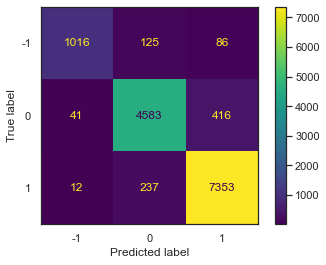

In [53]:
# Classification report
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
y_pred_train = mygrid_trainset.predict(X_train)



y_train = y_train
sns.set_theme(style='white')
def class_report(model,y_train,y_pred_train):
    print(classification_report(y_train,y_pred_train))
    cm = confusion_matrix(y_train,y_pred_train,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()


class_report(mygrid_trainset,y_train,y_pred_train)

**ROC on training data**

In [54]:
X = df_clean['vectors'].tolist()
y = df_clean['sentiment_label'].tolist()

In [55]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y,test_size=.2,random_state=42, 
                                            stratify=y)


# # Without PCA
hgb =HistGradientBoostingClassifier(max_depth=3, max_iter=300,
                                                max_leaf_nodes=20,
                                                min_samples_leaf=80,
                                                random_state=42,
                                                warm_start=True)

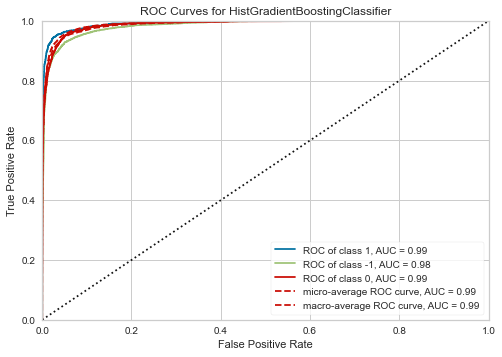

<AxesSubplot:title={'center':'ROC Curves for HistGradientBoostingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [56]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(hgb, classes=[-1,0,1])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_train, y_train)        # Evaluate the model on the training data
visualizer.show() 
# Without PCA: AUC score using OvR, macro-averaged over all classes: 0.99

A significant increase in performance in f1-score macro and AUC macro than the use of 50-vector space.

**Building the model with best estimator and testing on test data**

In [57]:
X = df_clean['vectors'].tolist()
y = df_clean['sentiment_label'].tolist()

In [58]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y,test_size=.2,random_state=42, 
                                            stratify=y)


# Without PCA
hgb =HistGradientBoostingClassifier(max_depth=3, max_iter=300,
                                                max_leaf_nodes=20,
                                                min_samples_leaf=80,
                                                random_state=42,
                                                warm_start=True)

hgb.fit(X_train,y_train)

HistGradientBoostingClassifier(max_depth=3, max_iter=300, max_leaf_nodes=20,
                               min_samples_leaf=80, random_state=42,
                               warm_start=True)

              precision    recall  f1-score   support

          -1       0.72      0.48      0.57       307
           0       0.78      0.78      0.78      1260
           1       0.86      0.91      0.89      1901

    accuracy                           0.83      3468
   macro avg       0.79      0.72      0.75      3468
weighted avg       0.82      0.83      0.82      3468



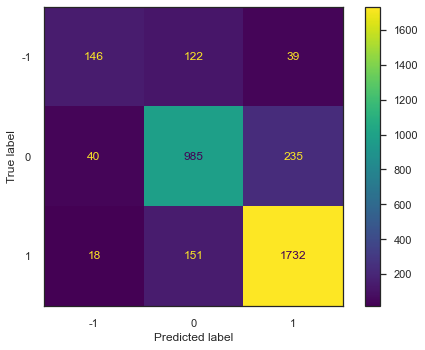

In [59]:
# Classification report test data
y_test = y_test
y_pred_test = hgb.predict(X_test)
sns.set_theme(style='white')
def class_report(model,y_test,pred):
    print(classification_report(y_test,pred))
    cm = confusion_matrix(y_test,pred,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()


class_report(hgb,y_test,y_pred_test)

**ROC on test data**

In [60]:
X = df_clean['vectors'].tolist()
y = df_clean['sentiment_label'].tolist()

In [61]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y,test_size=.2,random_state=42, 
                                            stratify=y)


# Without PCA
hgb =HistGradientBoostingClassifier(max_depth=3, max_iter=300,
                                                max_leaf_nodes=20,
                                                min_samples_leaf=80,
                                                random_state=42,
                                                warm_start=True)

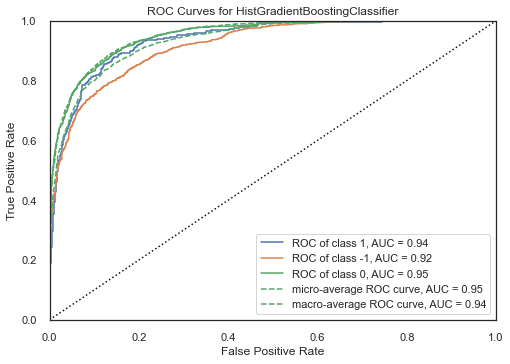

<AxesSubplot:title={'center':'ROC Curves for HistGradientBoostingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [62]:
# Without PCA
visualizer = ROCAUC(hgb, classes=[-1,0,1])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show() 
# Without PCA: AUC score using OvR, macro-averaged over all classes: 0.94

## **Conclusion**

- Using glove-twitter-100 word embeddings has shown great performance than the use of 25 and 50 vector space.


**Table of Values**

dataset|f1_score_macro_avg|AUC_score_avg
| ----------- | ----------- | ----------- |
df_clean_(train data)|0.92|0.99
df_clean (test data)|0.75|0.94